In [4]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [5]:
x_data = pd.read_excel("Shenyan_S82_ESPdescriptor+汪老师提取的所有特征-不含FE.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [6]:
y_data = pd.read_csv("Target.csv", usecols=[5])
y_data

,FE acetate
0,1.979396
1,1.619098
2,1.112448
3,2.288868
4,2.006888
...,...
77,2.489478
78,2.585958
79,3.074849
80,2.609417


In [7]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [8]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [9]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [19]:
selected

[106,
 32,
 136,
 303,
 3,
 27,
 155,
 97,
 165,
 241,
 17,
 180,
 0,
 1,
 2,
 4,
 183,
 6,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 58,
 240,
 242,
 251,
 61,
 14,
 45,
 249,
 139,
 19,
 21,
 10,
 44,
 55,
 51,
 38,
 118,
 306,
 90,
 212,
 232,
 252,
 22,
 23,
 255,
 133,
 82,
 29,
 25,
 153,
 250,
 216,
 276,
 163,
 28,
 34,
 282,
 198,
 59,
 243,
 278,
 237,
 246,
 234,
 98,
 81,
 57,
 79,
 304,
 130,
 154,
 116,
 70,
 219,
 78,
 148,
 302,
 253,
 264,
 114,
 144,
 169,
 49,
 190,
 300,
 52,
 8,
 291,
 262,
 146,
 258,
 259,
 261,
 160,
 134,
 281,
 137,
 301,
 129,
 119,
 95,
 91,
 103,
 162,
 87,
 192,
 123,
 167,
 293,
 191,
 96,
 72,
 263,
 168,
 108,
 295,
 181,
 274,
 73,
 193,
 305,
 141,
 99,
 77,
 104,
 268,
 182,
 69,
 93,
 161,
 254,
 195,
 143,
 67,
 196,
 284,
 66,
 63,
 64,
 294,
 74,
 150,
 189,
 68,
 269,
 152,
 71,
 122,
 186,
 159,
 42,
 117,
 270,
 299,
 296,
 128,
 187,
 279,
 289,
 184,
 94,
 

In [14]:
train_mse_list

[0.01683169775598146,
 0.016592342888735945,
 0.012406407643653097,
 0.010562553720769228,
 0.011543302304976952,
 0.011452351583408687,
 0.011215170195490665,
 0.011323071609525424,
 0.011256439942798761,
 0.011427149988941555,
 0.011529894806237326,
 0.011582128728049151,
 0.0116211087353657,
 0.01165036103002498,
 0.011672779147638932,
 0.011695308434636687,
 0.011709522283839762,
 0.011724580637826259,
 0.011739426184625769,
 0.011747856203649225,
 0.011757470378547331,
 0.011764167929809378,
 0.01177108510324501,
 0.011776763364296531,
 0.011781587128408119,
 0.011786034426053284,
 0.011792432476658688,
 0.011794879032729105,
 0.01179870207226115,
 0.011803409126502223,
 0.011804535466869862,
 0.011809637420030088,
 0.011812964388347369,
 0.011815182322946632,
 0.01181955332733457,
 0.011822789198843725,
 0.011821764667856194,
 0.01182563761743975,
 0.011827439828631426,
 0.011829869099810864,
 0.011886156115937836,
 0.011913168745196736,
 0.011947872732901054,
 0.0119798388515125

In [15]:
val_mse_list

[0.017806784272270983,
 0.01792394968175991,
 0.016581354888043076,
 0.015642085218821912,
 0.01551398475220482,
 0.0149786711602484,
 0.01466603371967617,
 0.014434478658873004,
 0.01437153837021131,
 0.014211864852042616,
 0.014209479505169978,
 0.014234272332387637,
 0.014245630609660767,
 0.014253880893726412,
 0.014266203778572285,
 0.014275686486857597,
 0.014280103304617398,
 0.01428777183603499,
 0.014300886412735806,
 0.014308627414712786,
 0.014320104829356977,
 0.014324825827973947,
 0.014322594350265746,
 0.014343440769190554,
 0.014338942377388622,
 0.014342595764204663,
 0.014346009668856541,
 0.01434484244482569,
 0.01435785423089884,
 0.01435304898481438,
 0.014359895557271556,
 0.014360223413063788,
 0.0143620212951819,
 0.01436484588850415,
 0.014371143685917433,
 0.01437696607161507,
 0.014375510374882956,
 0.014371256901209838,
 0.014380704956376495,
 0.014380664785437588,
 0.014403336144451762,
 0.014426153486198062,
 0.01445521717886541,
 0.01448525939539741,
 0.0

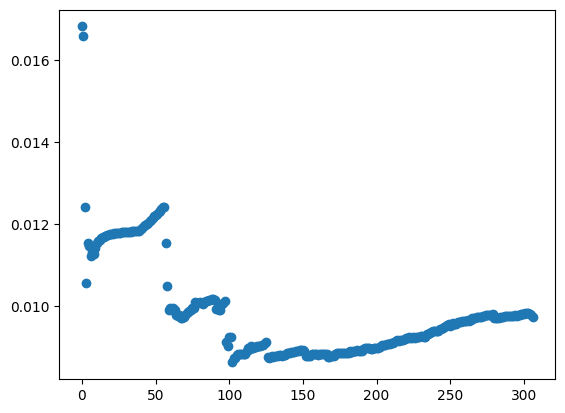

In [16]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

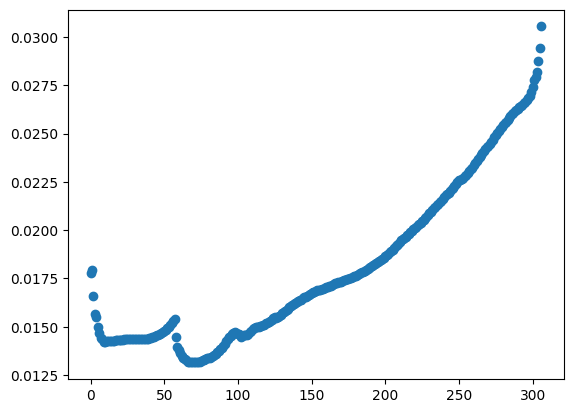

In [17]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [10]:
val_mse_list = [0.017806784272270983,
 0.01792394968175991,
 0.016581354888043076,
 0.015642085218821912,
 0.01551398475220482,
 0.0149786711602484,
 0.01466603371967617,
 0.014434478658873004,
 0.01437153837021131,
 0.014211864852042616,
 0.014209479505169978,
 0.014234272332387637,
 0.014245630609660767,
 0.014253880893726412,
 0.014266203778572285,
 0.014275686486857597,
 0.014280103304617398,
 0.01428777183603499,
 0.014300886412735806,
 0.014308627414712786,
 0.014320104829356977,
 0.014324825827973947,
 0.014322594350265746,
 0.014343440769190554,
 0.014338942377388622,
 0.014342595764204663,
 0.014346009668856541,
 0.01434484244482569,
 0.01435785423089884,
 0.01435304898481438,
 0.014359895557271556,
 0.014360223413063788,
 0.0143620212951819,
 0.01436484588850415,
 0.014371143685917433,
 0.01437696607161507,
 0.014375510374882956,
 0.014371256901209838,
 0.014380704956376495,
 0.014380664785437588,
 0.014403336144451762,
 0.014426153486198062,
 0.01445521717886541,
 0.01448525939539741,
 0.014510690830423422,
 0.014548040158244579,
 0.014587728315296245,
 0.014620735419271932,
 0.014662748016231056,
 0.01471442786335751,
 0.014762415028409203,
 0.01483196051779529,
 0.014908302243994346,
 0.014983263257899926,
 0.015078118949621123,
 0.015175050989581787,
 0.015294045074936221,
 0.015377290151720343,
 0.014451873259952832,
 0.013950743500940577,
 0.013802979817774255,
 0.013657406249854448,
 0.013465926151956506,
 0.013398109663040739,
 0.013337816704325623,
 0.013272095380949075,
 0.013190285408255977,
 0.013152066434247853,
 0.013146203742965226,
 0.01315044945114018,
 0.013149282480890052,
 0.013168457821107895,
 0.013165314786937521,
 0.013177014018335226,
 0.013195755577709268,
 0.013238459445565459,
 0.013249578360140967,
 0.013283713953448267,
 0.01330628292936189,
 0.013358248045648885,
 0.013382512517134756,
 0.013393356603785248,
 0.013430630065570262,
 0.01347838625345513,
 0.013524153166474397,
 0.013598690537543553,
 0.013669190288123245,
 0.01374441307736159,
 0.013820330409447103,
 0.013882134446551947,
 0.013994198040400618,
 0.014116990648933412,
 0.014236039586219482,
 0.014363390847106583,
 0.014469073974143213,
 0.014528605612952689,
 0.014605567673296857,
 0.01464951542202545,
 0.01471583903261806,
 0.01467457828350768,
 0.014604732857789108,
 0.014596627233409935,
 0.014480221942491569,
 0.014502342988697367,
 0.01456835385398709,
 0.014557876794259319,
 0.014580378410516213,
 0.014636469143421194,
 0.014710380478306227,
 0.014796650421961034,
 0.014873558430437514,
 0.014948766605499066,
 0.014993978611931654,
 0.014993074393946001,
 0.015004418755887452,
 0.015048659002656015,
 0.015051155800320477,
 0.015102453947171588,
 0.015109604844853648,
 0.015166346997390796,
 0.015181971240071554,
 0.015235056903120017,
 0.01529579657246814,
 0.015362077338873223,
 0.015441477304688747,
 0.015508136226286792,
 0.01544889450804662,
 0.01549730745320781,
 0.015558165880986652,
 0.015624018051212524,
 0.015686925047993815,
 0.015736540802798536,
 0.01579504729162335,
 0.015858915716135662,
 0.015925601690401952,
 0.01600192533605069,
 0.016061241160982013,
 0.01612472452325615,
 0.016164677529932094,
 0.016219500708991294,
 0.01626912833536959,
 0.016307615248788276,
 0.01636214048089912,
 0.01639503612489389,
 0.01646914979705013,
 0.016513763293309544,
 0.01654373274176048,
 0.01659586538072774,
 0.016643223570098904,
 0.016696930724688443,
 0.016749003442571866,
 0.016786959332156508,
 0.01682192552528488,
 0.016856129014393775,
 0.01688308609290568,
 0.016920755951854164,
 0.016925363629242202,
 0.01694922780172723,
 0.01697414912133046,
 0.017005728716913308,
 0.01703748329196171,
 0.017052671765339988,
 0.017096327622009258,
 0.017132507020573798,
 0.017178339557825724,
 0.017210010876766206,
 0.01724919577512591,
 0.01727905250265884,
 0.017296009484487108,
 0.017308506347553838,
 0.01733535062279348,
 0.017377181044602768,
 0.017421865337251517,
 0.01742581491204872,
 0.017454770484208775,
 0.01748374362393428,
 0.017503856788165264,
 0.017547275015538585,
 0.017577830808125652,
 0.01761729039250228,
 0.01764018095587406,
 0.0176875438027355,
 0.01772142312499728,
 0.01776553235637049,
 0.01781430259234275,
 0.017849459255645996,
 0.01790951065235339,
 0.017948502673310714,
 0.018003613996514935,
 0.018047448945993538,
 0.018112523216403047,
 0.018163057430649044,
 0.018211672684935995,
 0.01825987827480044,
 0.018309601516791445,
 0.018350624689636934,
 0.01840947073975414,
 0.018463860565278066,
 0.018522242667192917,
 0.01857961513865667,
 0.01864365399778472,
 0.01870499744206968,
 0.018774458396874003,
 0.018849992079774225,
 0.018906513751810735,
 0.01898114862812968,
 0.019066696117658648,
 0.01915904913891163,
 0.019232786582933495,
 0.01930210777244782,
 0.019388039778157215,
 0.01946995898110791,
 0.019558936384493603,
 0.019584751998401765,
 0.01965432284352463,
 0.019730247215915795,
 0.019813789888808865,
 0.01989016352960244,
 0.019969127094288396,
 0.020052408528363614,
 0.02011346482775126,
 0.020185077870581773,
 0.020260167086655057,
 0.020324365298003456,
 0.02039501717258376,
 0.020468522237629856,
 0.020544529269721248,
 0.020609563224781587,
 0.02070184057749154,
 0.02079691313333914,
 0.020874886934100233,
 0.020955454147527613,
 0.021050006867789982,
 0.021138631314074705,
 0.02122288031972573,
 0.021311482010542452,
 0.021381427252159895,
 0.02145913215910941,
 0.021531506448401176,
 0.021610126084798585,
 0.021708602103415738,
 0.02179624125498723,
 0.02187190148710491,
 0.021946178752442376,
 0.02202403636731019,
 0.022108970952407266,
 0.022184862272721526,
 0.02229061648868725,
 0.022381011210226547,
 0.02249152586544461,
 0.02259013160217524,
 0.022582085310282933,
 0.022651776931351935,
 0.022710890752439695,
 0.02278295749744999,
 0.022868268033900793,
 0.022951202788760835,
 0.023059497359116717,
 0.02314652055194951,
 0.023234060499645888,
 0.023353816833448674,
 0.023460172240010742,
 0.023566903870458303,
 0.02369114504411792,
 0.02379963440818596,
 0.023897367665478217,
 0.02400154619303575,
 0.02410727100214907,
 0.024201874423621723,
 0.02430069176071719,
 0.02437342247967699,
 0.02447874081586375,
 0.024583147752427804,
 0.024691498862048366,
 0.02480447170668735,
 0.02491254088239927,
 0.02502241172515719,
 0.025126642391683007,
 0.025233567381269473,
 0.025343272500658393,
 0.025447162911040995,
 0.02552772346389056,
 0.025624824912963407,
 0.025722834235123913,
 0.025821313693133497,
 0.025915773103175454,
 0.02599637498037328,
 0.026074477188417655,
 0.026149479586282675,
 0.026232864684414325,
 0.026294597885541327,
 0.026356636616054085,
 0.02643325308514922,
 0.02649642501610868,
 0.026588019336536685,
 0.02665522610737196,
 0.026740280863765297,
 0.026826652525063804,
 0.026932236744182096,
 0.027147261361825333,
 0.02742371119909299,
 0.027764053259680187,
 0.027947022267041877,
 0.028198056011358913,
 0.028756913545895983,
 0.029449153405080607,
 0.030552008014484173]
min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

68
0.013146203742965226


In [11]:
selected = [106,
 32,
 136,
 303,
 3,
 27,
 155,
 97,
 165,
 241,
 17,
 180,
 0,
 1,
 2,
 4,
 183,
 6,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 58,
 240,
 242,
 251,
 61,
 14,
 45,
 249,
 139,
 19,
 21,
 10,
 44,
 55,
 51,
 38,
 118,
 306,
 90,
 212,
 232,
 252,
 22,
 23,
 255,
 133,
 82,
 29,
 25,
 153,
 250,
 216,
 276,
 163,
 28,
 34,
 282,
 198,
 59,
 243,
 278,
 237,
 246,
 234,
 98,
 81,
 57,
 79,
 304,
 130,
 154,
 116,
 70,
 219,
 78,
 148,
 302,
 253,
 264,
 114,
 144,
 169,
 49,
 190,
 300,
 52,
 8,
 291,
 262,
 146,
 258,
 259,
 261,
 160,
 134,
 281,
 137,
 301,
 129,
 119,
 95,
 91,
 103,
 162,
 87,
 192,
 123,
 167,
 293,
 191,
 96,
 72,
 263,
 168,
 108,
 295,
 181,
 274,
 73,
 193,
 305,
 141,
 99,
 77,
 104,
 268,
 182,
 69,
 93,
 161,
 254,
 195,
 143,
 67,
 196,
 284,
 66,
 63,
 64,
 294,
 74,
 150,
 189,
 68,
 269,
 152,
 71,
 122,
 186,
 159,
 42,
 117,
 270,
 299,
 296,
 128,
 187,
 279,
 289,
 184,
 94,
 102,
 286,
 88,
 131,
 48,
 151,
 121,
 142,
 267,
 80,
 85,
 194,
 197,
 225,
 231,
 46,
 164,
 201,
 207,
 290,
 222,
 76,
 257,
 86,
 277,
 188,
 272,
 203,
 100,
 211,
 213,
 176,
 30,
 209,
 111,
 202,
 288,
 204,
 109,
 120,
 208,
 283,
 127,
 5,
 210,
 157,
 275,
 101,
 271,
 185,
 113,
 229,
 83,
 292,
 138,
 112,
 205,
 24,
 285,
 217,
 75,
 124,
 214,
 218,
 228,
 233,
 107,
 92,
 287,
 7,
 178,
 206,
 105,
 215,
 89,
 166,
 260,
 273,
 265,
 266,
 256,
 115,
 220,
 223,
 149,
 235,
 145,
 158,
 156,
 12,
 170,
 224,
 298,
 125,
 236,
 173,
 174,
 200,
 135,
 65,
 84,
 238,
 175,
 239,
 247,
 244,
 248,
 245,
 226,
 221,
 230,
 179,
 177,
 227,
 199,
 171,
 147,
 172,
 132,
 280,
 50,
 126,
 140,
 297,
 31,
 54]

#for i in selected[:18]:
    #j = sorted_index[i]
    #print('{}'.format(x_train.columns[j]))

In [12]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

PEOE_VSA8
Disulfide
EState_VSA7
Atom1_ESP Pi (kcal/mol)
c1ccncc1
Primary_arom_amine
NumAliphaticRings
PEOE_VSA12
NumSaturatedRings
Conju_LogP_Std
Alkene
Atom_PEOE-Charge_Sum
c1nc_nH_n1
c1c_nH_cn1
c1cc_nH_c1
c1ccc2_nH_ccc2c1
Atom_PEOE-Charge_Mean
c1ccc2cc3ccccc3cc2c1
c1cn_nH_c1
c1cc2ccc(ccnccc3ccc(ccn1)_nH_3)_nH_2
c1nnn_nH_1
c1ccc2ncccc2c1
c1nncs1
Alkylchloride
Alkylbromide
Tertiary_aliph_amine
Aldehyde
Oxime
Acetal
Hemiacetal
Chloroalkene
Bromoalkene
Enol
Carboxylic_ester
Nitrile
Aryliodide
Azo
Phosphonic_acid_derivative
Sugar_pattern_combi
SMR_VSA2
Sulfon
Conju_PEOE-Charge_Std
Conju_MR_Std
Conju_MR_Delta
Tri_boron
c1ccc2sc_n+_c2c1
Amide
Conju_PEOE-Charge_Delta
VSA_EState1
Alkylfluoride
Trifluoromethyl
c1ccc2occcc2c1
Lactone
Oxoarene
Arylfluoride
Thioacetal
SlogP_VSA10
Iaverage / mA cm-2
Kappa1
Fun_MR_Min
Mid-Fun_LogP_Delta
Atom Number
Alcohol
Althoxyl
HOMO
EState_VSA4
Chi1v
Tertiary_arom_amine
Secondary_aliph_amine


In [21]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
import os
# 指定图像保存的路径
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-n-acetate.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,PEOE_VSA8,Disulfide,EState_VSA7,Atom1_ESP Pi (kcal/mol),c1ccncc1,Primary_arom_amine,NumAliphaticRings,PEOE_VSA12,NumSaturatedRings,Conju_LogP_Std,Alkene,Atom_PEOE-Charge_Sum,c1nc_nH_n1,c1c_nH_cn1,c1cc_nH_c1,c1ccc2_nH_ccc2c1,Atom_PEOE-Charge_Mean,c1ccc2cc3ccccc3cc2c1,c1cn_nH_c1,c1cc2ccc(ccnccc3ccc(ccn1)_nH_3)_nH_2,c1nnn_nH_1,c1ccc2ncccc2c1,c1nncs1,Alkylchloride,Alkylbromide,Tertiary_aliph_amine,Aldehyde,Oxime,Acetal,Hemiacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_ester,Nitrile,Aryliodide,Azo,Phosphonic_acid_derivative,Sugar_pattern_combi,SMR_VSA2,Sulfon,Conju_PEOE-Charge_Std,Conju_MR_Std,Conju_MR_Delta,Tri_boron,c1ccc2sc_n+_c2c1,Amide,Conju_PEOE-Charge_Delta,VSA_EState1,Alkylfluoride,Trifluoromethyl,c1ccc2occcc2c1,Lactone,Oxoarene,Arylfluoride,Thioacetal,SlogP_VSA10,Iaverage / mA cm-2,Kappa1,Fun_MR_Min,Mid-Fun_LogP_Delta,Atom Number,Alcohol,Althoxyl,HOMO,EState_VSA4,Chi1v,Tertiary_arom_amine,Secondary_aliph_amine
0,4.776499,0,0.000000,13.207422,0,0,0,0.0,0,0.0,0,1.670000e-16,0,0,0,0,9.250000e-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,1,0,0,0.000000e+00,0.398333,0,0,0,0,0,0,0,0.0,142.333333,8.451507,5.2285,0.3808,18,0,0,-0.256346,11.336786,3.894626,0,0
1,0.000000,0,17.512797,12.774025,0,0,0,0.0,0,0.0,0,-4.160000e-17,0,0,0,0,-4.630000e-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,1.196759,0,0,0,0,0,0,0,0.0,133.000000,4.341812,8.9270,0.0000,9,0,0,-0.237867,0.000000,3.256802,0,0
2,0.000000,0,0.000000,14.830128,0,0,0,0.0,0,0.0,0,2.780000e-17,0,0,0,0,3.080000e-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0.0,134.666667,4.820000,7.6358,0.8027,9,0,0,-0.263323,0.000000,1.729968,0,0
3,11.505707,1,0.000000,15.026383,0,0,0,0.0,0,0.0,0,-2.220000e-16,0,0,0,0,-1.010000e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0.0,107.333333,11.640000,7.6358,1.7186,22,0,0,-0.240901,0.000000,5.794619,0,0
4,11.505707,0,23.913925,14.378481,0,0,0,0.0,0,0.0,2,6.940000e-18,0,0,0,0,4.080000e-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.040000e-17,0.0,0.0,0,0,0,2.080000e-17,0.000000,0,0,0,0,0,0,0,0.0,88.000000,6.830000,10.1970,0.0000,17,0,0,-0.226450,11.505707,3.365044,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.000000,0,0.000000,13.985197,0,0,0,0.0,0,0.0,0,-2.780000e-17,0,0,0,0,-8.160000e-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0.0,85.333333,12.700000,8.9860,0.0000,34,0,0,-0.239577,11.505707,6.397367,0,0
78,0.000000,0,0.000000,14.029267,0,0,0,0.0,0,0.0,0,-5.550000e-17,0,0,0,0,-1.980000e-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0.0,108.333333,10.700000,8.9860,0.0000,28,0,0,-0.239609,11.505707,5.397367,0,0
79,0.000000,0,0.000000,14.192581,0,0,0,0.0,0,0.0,0,1.110000e-16,0,0,0,0,5.840000e-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0.0,83.666667,7.700000,8.9860,0.0000,19,0,0,-0.239940,11.505707,3.897367,0,0
80,0.000000,0,0.000000,14.306475,0,0,0,0.0,0,0.0,0,-1.670000e-16,0,0,0,0,-1.040000e-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.0,0.0,0,0,0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0.0,97.666667,6.700000,8.9860,0.0000,16,0,0,-0.240430,11.505707,3.397367,0,0


In [15]:
from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-acetate.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['PEOE_VSA8', 'Disulfide', 'EState_VSA7', 'Atom1_ESP Pi (kcal/mol)', 'c1ccncc1', 'Primary_arom_amine', 'NumAliphaticRings', 'PEOE_VSA12', 'NumSaturatedRings', 'Conju_LogP_Std', 'Alkene', 'Atom_PEOE-Charge_Sum', 'c1nc_nH_n1', 'c1c_nH_cn1', 'c1cc_nH_c1', 'c1ccc2_nH_ccc2c1', 'Atom_PEOE-Charge_Mean', 'c1ccc2cc3ccccc3cc2c1', 'c1cn_nH_c1', 'c1cc2ccc(ccnccc3ccc(ccn1)_nH_3)_nH_2', 'c1nnn_nH_1', 'c1ccc2ncccc2c1', 'c1nncs1', 'Alkylchloride', 'Alkylbromide', 'Tertiary_aliph_amine', 'Aldehyde', 'Oxime', 'Acetal', 'Hemiacetal', 'Chloroalkene', 'Bromoalkene', 'Enol', 'Carboxylic_ester', 'Nitrile', 'Aryliodide', 'Azo', 'Phosphonic_acid_derivative', 'Sugar_pattern_combi', 'SMR_VSA2', 'Sulfon', 'Conju_PEOE-Charge_Std', 'Conju_MR_Std', 'Conju_MR_Delta', 'Tri_boron', 'c1ccc2sc_n+_c2c1', 'Amide', 'Conju_PEOE-Charge_Delta', 'VSA_EState1', 'Alkylfluoride', 'Trifluoromethyl', 'c1ccc2occcc2c1', 'Lactone', 'Oxoarene', 'Arylfluoride', 'Thioacetal', 'SlogP_VSA10', 'Iav